In [ ]:
from pathlib import Path
import pandas as pd

# ==========================
# Chargement de df13.parquet
# ==========================

ROOT = Path.cwd()
if ROOT.name == "src":   
    ROOT = ROOT.parent

DB = ROOT / "data" / "database"
print("Dossier database :", DB)

df13_path = DB / "df13.parquet"
print("Fichier utilisé :", df13_path)

df13 = pd.read_parquet(df13_path)
print("Shape df13 :", df13.shape)
df13.head()


Dossier database : /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK/data/database
Fichier utilisé : /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK/data/database/df13.parquet
Shape df13 : (584400, 17)


,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,SWI,SSWI_10J,ALEA,NIVEAU,DPT,ARGILES_FROM,dist_argiles_m,COMMUNE,DEPARTEMENT,REGION
0,7560,18330,20000101,0.0,0.0,3.9,1.9,0.566,0.071,Moyen,2.0,13,within,NaN,Saintes-Maries-de-la-Mer,13,93
1,7560,18330,20000102,0.0,0.2,5.5,3.3,0.564,0.066,Moyen,2.0,13,within,NaN,Saintes-Maries-de-la-Mer,13,93
2,7560,18330,20000103,0.0,0.0,5.5,2.6,0.560,0.062,Moyen,2.0,13,within,NaN,Saintes-Maries-de-la-Mer,13,93
3,7560,18330,20000104,0.0,0.0,6.8,1.8,0.555,0.058,Moyen,2.0,13,within,NaN,Saintes-Maries-de-la-Mer,13,93
4,7560,18330,20000105,0.0,0.1,6.1,2.1,0.553,0.053,Moyen,2.0,13,within,NaN,Saintes-Maries-de-la-Mer,13,93


In [3]:
from sklearn.model_selection import train_test_split

# Colonnes numériques
num_cols = ["PRENEI", "PRELIQ", "T", "FF", "SSWI_10J"]
num_cols = [c for c in num_cols if c in df13.columns]

# Colonnes catégorielles
cat_cols = []
if "ALEA" in df13.columns:
    cat_cols.append("ALEA")
if "NIVEAU" in df13.columns:
    cat_cols.append("NIVEAU")

print("Numériques :", num_cols)
print("Catégorielles :", cat_cols)

# On garde seulement les colonnes utiles + SWI
cols_needed = ["SWI"] + num_cols + cat_cols
df13_model = df13[cols_needed].dropna().copy()
print("Taille après dropna :", df13_model.shape)

# Encodage des variables catégorielles (one-hot)
X = pd.get_dummies(df13_model[num_cols + cat_cols], drop_first=True)
y = df13_model["SWI"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

X_train.shape, X_test.shape


Numériques : ['PRENEI', 'PRELIQ', 'T', 'FF', 'SSWI_10J']
Catégorielles : ['ALEA', 'NIVEAU']
Taille après dropna : (584400, 8)


((467520, 7), (116880, 7))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ==========================
# Random Forest simple
# ==========================

rf = RandomForestRegressor(
    n_estimators=200,      
    max_depth=None,       
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",  
    random_state=0,
    n_jobs=-1
)

# Entraînement
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Scores
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - R² (test)  : {r2_rf:.3f}")
print(f"Random Forest - RMSE (test): {rmse_rf:.3f}")


Random Forest - R² (test)  : 0.864
Random Forest - RMSE (test): 0.093


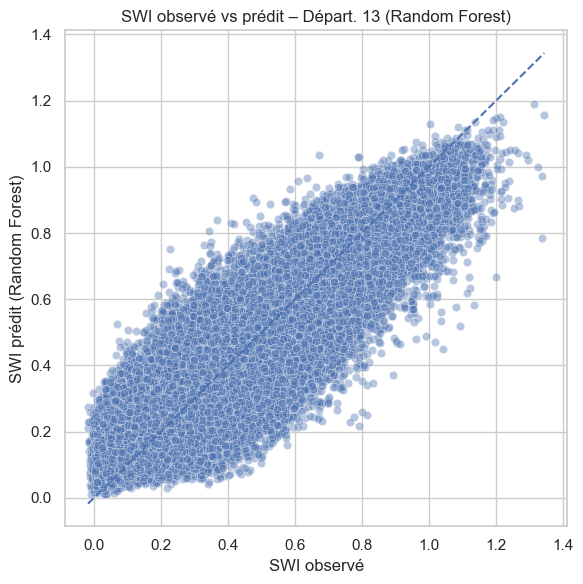

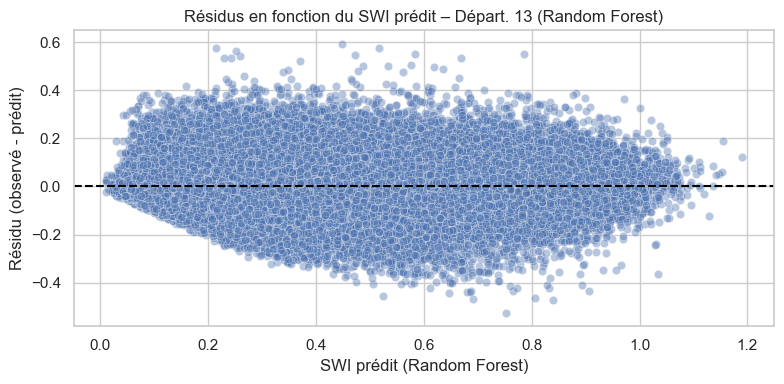

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# --- Observé vs prédit (Random Forest) ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.4)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("SWI observé")
plt.ylabel("SWI prédit (Random Forest)")
plt.title("SWI observé vs prédit – Départ. 13 (Random Forest)")
plt.tight_layout()
plt.show()

# --- Résidus ---
res_rf = y_test - y_pred_rf

plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred_rf, y=res_rf, alpha=0.4)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("SWI prédit (Random Forest)")
plt.ylabel("Résidu (observé - prédit)")
plt.title("Résidus en fonction du SWI prédit – Départ. 13 (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:

sns.set_theme(style="whitegrid")

# Série des importances
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Affichage brut
importances


T             0.485996
SSWI_10J      0.411958
FF            0.061368
PRELIQ        0.034666
PRENEI        0.002697
ALEA_Moyen    0.001692
NIVEAU        0.001624
dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ==========================
# Modèle linéaire
# ==========================

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédictions sur le même X_test que le RF
y_pred_lin = linreg.predict(X_test)

# Scores linéaire
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print(f"Modèle linéaire - R² (test)  : {r2_lin:.3f}")
print(f"Modèle linéaire - RMSE (test): {rmse_lin:.3f}")


Modèle linéaire - R² (test)  : 0.733
Modèle linéaire - RMSE (test): 0.131


In [8]:
import pandas as pd

results = pd.DataFrame({
    "Modèle": ["Linéaire", "Random Forest"],
    "R2_test": [r2_lin, r2_rf],
    "RMSE_test": [rmse_lin, rmse_rf]
})

results
print("\nComparaison des modèles :")
print(results.to_string(index=False))



Comparaison des modèles :
       Modèle  R2_test  RMSE_test
     Linéaire 0.732977   0.131016
Random Forest 0.864175   0.093441


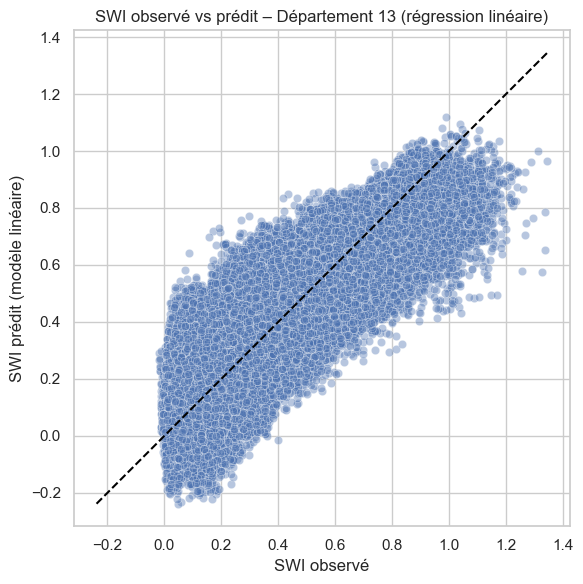

In [ ]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.4)

# Ligne idéale (prédiction parfaite)
min_val = min(y_test.min(), y_pred_lin.min())
max_val = max(y_test.max(), y_pred_lin.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black")

plt.xlabel("SWI observé")
plt.ylabel("SWI prédit (modèle linéaire)")
plt.title("SWI observé vs prédit – Département 13 (régression linéaire)")
plt.tight_layout()
plt.show()


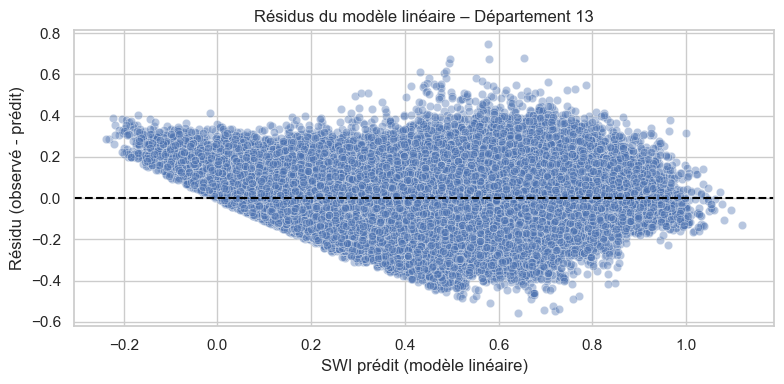

In [10]:
residuals_lin = y_test - y_pred_lin

plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred_lin, y=residuals_lin, alpha=0.4)

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("SWI prédit (modèle linéaire)")
plt.ylabel("Résidu (observé - prédit)")
plt.title("Résidus du modèle linéaire – Département 13")
plt.tight_layout()
plt.show()


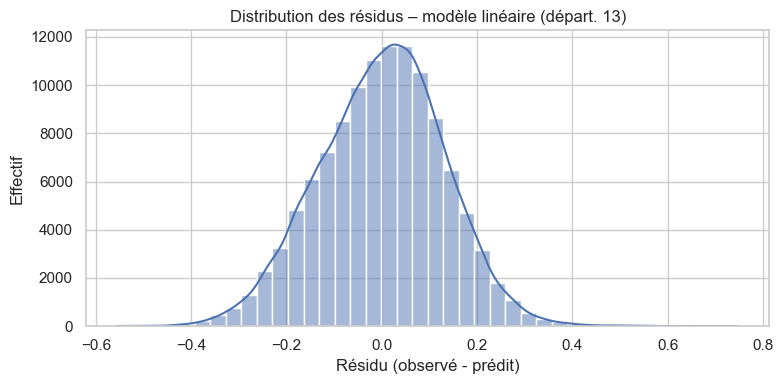

In [ ]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,4))
sns.histplot(residuals_lin, bins=40, kde=True)
plt.title("Distribution des résidus – modèle linéaire (départ. 13)")
plt.xlabel("Résidu (observé - prédit)")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()


<Figure size 500x500 with 0 Axes>

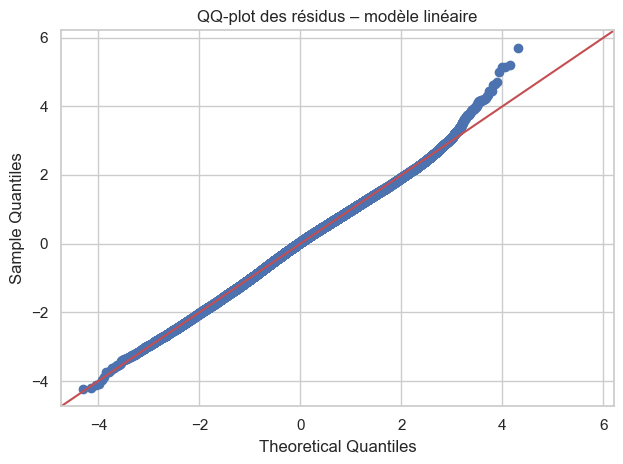

In [12]:
import statsmodels.api as sm

plt.figure(figsize=(5,5))
sm.qqplot(residuals_lin, line="45", fit=True)
plt.title("QQ-plot des résidus – modèle linéaire")
plt.tight_layout()
plt.show()


In [13]:
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# Durbin-Watson
dw = durbin_watson(residuals_lin)
print(f"Durbin–Watson : {dw:.3f}")

# Jarque–Bera (normalité)
jb_stat, jb_pvalue, skew, kurt = jarque_bera(residuals_lin)
print(f"Jarque–Bera : statistique = {jb_stat:.3f}, p-value = {jb_pvalue:.3g}")
print(f"Asymétrie (skew) : {skew:.3f}")
print(f"Excès de kurtosis : {kurt:.3f}")


Durbin–Watson : 2.001
Jarque–Bera : statistique = 129.186, p-value = 8.86e-29
Asymétrie (skew) : -0.079
Excès de kurtosis : 3.038


## Intégration d'une nouvelle base pour la modélisation

In [ ]:
import numpy as np
from pathlib import Path

# Trouver la racine du projet (celle qui contient le dossier "data")
ROOT = Path.cwd().resolve()
while ROOT != ROOT.parent and not (ROOT / "data").exists():
    ROOT = ROOT.parent

DATA_DB   = ROOT / "data" / "database"
DATA_PROC = ROOT / "data" / "processed"

df13 = pd.read_parquet(DATA_DB / "df13.parquet")
dfm  = pd.read_parquet(DATA_DB / "base_13_modelisation_argiles_brgm.parquet")
comm = pd.read_parquet(DATA_PROC / "commune.parquet")   # contient en général nom commune + code INSEE

print("df13:", df13.shape)
print("dfm :", dfm.shape, dfm.columns.tolist())
print("comm:", comm.shape, comm.columns.tolist())


df13: (584400, 17)
dfm : (119, 3) ['code_insee', 'alea_dom', 'alea_share']
comm: (34746, 17) ['cleabs', 'nom_officiel', 'nom_officiel_en_majuscules', 'statut', 'code_insee', 'population', 'date_du_recensement', 'organisme_recenseur', 'code_insee_du_canton', 'code_insee_de_l_arrondissement', 'code_insee_du_departement', 'code_insee_de_la_region', 'codes_siren_des_epci', 'code_siren', 'code_postal', 'superficie_cadastrale', 'geometry']


In [19]:
import unicodedata
import re

def norm_commune(s):
    s = "" if pd.isna(s) else str(s)
    s = s.lower().strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[-']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [22]:
print(comm.columns.tolist())
comm.head()

['cleabs', 'nom_officiel', 'nom_officiel_en_majuscules', 'statut', 'code_insee', 'population', 'date_du_recensement', 'organisme_recenseur', 'code_insee_du_canton', 'code_insee_de_l_arrondissement', 'code_insee_du_departement', 'code_insee_de_la_region', 'codes_siren_des_epci', 'code_siren', 'code_postal', 'superficie_cadastrale', 'geometry']


,cleabs,nom_officiel,nom_officiel_en_majuscules,statut,code_insee,population,date_du_recensement,organisme_recenseur,code_insee_du_canton,code_insee_de_l_arrondissement,code_insee_du_departement,code_insee_de_la_region,codes_siren_des_epci,code_siren,code_postal,superficie_cadastrale,geometry
0,COMMUNE_0000000000001001,L'Abergement-Clémenciat,L'ABERGEMENT-CLEMENCIAT,Commune simple,01001,859,2022-01-01,INSEE,0108,012,01,84,200069193,210100012,01400,1590,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
1,COMMUNE_0000000000001002,L'Abergement-de-Varey,L'ABERGEMENT-DE-VAREY,Commune simple,01002,273,2022-01-01,INSEE,0101,011,01,84,240100883,210100020,01640,920,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
2,COMMUNE_0000000000001004,Ambérieu-en-Bugey,AMBERIEU-EN-BUGEY,Commune simple,01004,15554,2022-01-01,INSEE,0101,011,01,84,240100883,210100046,01500,2460,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
3,COMMUNE_0000000000001005,Ambérieux-en-Dombes,AMBERIEUX-EN-DOMBES,Commune simple,01005,1917,2022-01-01,INSEE,0122,012,01,84,200042497,210100053,01330,1590,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...
4,COMMUNE_0000000000001006,Ambléon,AMBLEON,Commune simple,01006,114,2022-01-01,INSEE,0104,011,01,84,200040350,210100061,01300,590,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...


In [23]:
print(df13["COMMUNE"].nunique(), df13["COMMUNE"].head(5).tolist())

52 ['Saintes-Maries-de-la-Mer', 'Saintes-Maries-de-la-Mer', 'Saintes-Maries-de-la-Mer', 'Saintes-Maries-de-la-Mer', 'Saintes-Maries-de-la-Mer']


In [24]:
def norm_txt(s):
    s = "" if pd.isna(s) else str(s)
    s = s.strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))  # enlève accents
    s = re.sub(r"['’\-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# dept code dans df13 (souvent '13' déjà) -> string zfill(2)
df13["dep_key"] = df13["DEPARTEMENT"].astype(str).str.zfill(2)
df13["com_key"] = df13["COMMUNE"].map(norm_txt)
df13["key_join"] = df13["dep_key"] + "|" + df13["com_key"]

# table communes : on prend le dept INSEE + nom officiel
comm["dep_key"] = comm["code_insee_du_departement"].astype(str).str.zfill(2)
comm["com_key"] = comm["nom_officiel"].map(norm_txt)
comm["key_join"] = comm["dep_key"] + "|" + comm["com_key"]

# (optionnel) on filtre direct sur dep 13 côté comm pour accélérer
comm13 = comm[comm["dep_key"] == "13"][["key_join", "code_insee"]].drop_duplicates()
print("comm13:", comm13.shape)


comm13: (119, 2)


In [ ]:
def norm_txt(s):
    s = "" if pd.isna(s) else str(s)
    s = s.strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) 
    s = re.sub(r"['’\-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df13["dep_key"] = df13["DEPARTEMENT"].astype(str).str.zfill(2)
df13["com_key"] = df13["COMMUNE"].map(norm_txt)
df13["key_join"] = df13["dep_key"] + "|" + df13["com_key"]

# table communes : on prend le dept INSEE + nom officiel
comm["dep_key"] = comm["code_insee_du_departement"].astype(str).str.zfill(2)
comm["com_key"] = comm["nom_officiel"].map(norm_txt)
comm["key_join"] = comm["dep_key"] + "|" + comm["com_key"]

# (optionnel) on filtre direct sur dep 13 côté comm pour accélérer
comm13 = comm[comm["dep_key"] == "13"][["key_join", "code_insee"]].drop_duplicates()
print("comm13:", comm13.shape)


comm13: (119, 2)


In [26]:
df13_plus = df13.merge(comm13, on="key_join", how="left")

print("Taux code_insee manquant:", df13_plus["code_insee"].isna().mean())

# join sur dfm (alea_dom/alea_share)
df13_full = df13_plus.merge(dfm, on="code_insee", how="left")

print("Taux alea_share manquant:", df13_full["alea_share"].isna().mean())
df13_full[["COMMUNE","DEPARTEMENT","code_insee","alea_dom","alea_share"]].head()


Taux code_insee manquant: 0.0
Taux alea_share manquant: 0.0


,COMMUNE,DEPARTEMENT,code_insee,alea_dom,alea_share
0,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
1,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
2,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
3,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
4,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0


In [28]:
print(df13_full)

        LAMBX  LAMBY      DATE  PRENEI  PRELIQ    T   FF    SWI  SSWI_10J  \
0        7560  18330  20000101     0.0     0.0  3.9  1.9  0.566     0.071   
1        7560  18330  20000102     0.0     0.2  5.5  3.3  0.564     0.066   
2        7560  18330  20000103     0.0     0.0  5.5  2.6  0.560     0.062   
3        7560  18330  20000104     0.0     0.0  6.8  1.8  0.555     0.058   
4        7560  18330  20000105     0.0     0.1  6.1  2.1  0.553     0.053   
...       ...    ...       ...     ...     ...  ...  ...    ...       ...   
584395   8760  18570  20191227     0.0     0.0  8.2  3.9  0.990     1.719   
584396   8760  18570  20191228     0.0     0.1  5.1  0.6  0.974     1.754   
584397   8760  18570  20191229     0.0     0.0  5.3  1.0  0.962     1.788   
584398   8760  18570  20191230     0.0     0.1  4.4  0.9  0.950     1.758   
584399   8760  18570  20191231     0.0     0.1  4.6  0.9  0.938     1.684   

         ALEA  ...                   COMMUNE DEPARTEMENT REGION  \
0       

In [ ]:
def norm_txt(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^a-z0-9]+", " ", s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

keep_cols = [c for c in ["DATE","COMMUNE","DEPARTEMENT","REGION","SWI","SSWI_10J","PRENEI","PRELIQ","T","FF","ALEA","NIVEAU"] if c in df13.columns]
df13_small = df13[keep_cols].copy()

# ---- Construire clé join dans df13 ----
df13_small["DEPARTEMENT"] = df13_small["DEPARTEMENT"].astype(str)
df13_small["_comm_norm"]  = df13_small["COMMUNE"].apply(norm_txt)
df13_small["key_join"]    = df13_small["DEPARTEMENT"] + "|" + df13_small["_comm_norm"]

# ---- Construire clé join dans comm (nom_officiel + code dep) ----
comm2 = comm.copy()
comm2["code_insee_du_departement"] = comm2["code_insee_du_departement"].astype(str)
comm2["_comm_norm"] = comm2["nom_officiel"].apply(norm_txt)
comm2["key_join"]   = comm2["code_insee_du_departement"] + "|" + comm2["_comm_norm"]

comm2 = comm2[["key_join","code_insee"]].drop_duplicates()

# ---- Join df13 -> code_insee ----
df13_full = df13_small.merge(comm2, on="key_join", how="left")

miss_code = df13_full["code_insee"].isna().mean()
print(f"Part de lignes df13 sans code_insee après join commune = {miss_code:.2%}")

# ---- Join code_insee -> (alea_dom, alea_share) via dfm ----
dfm2 = dfm.copy()
dfm2["code_insee"] = dfm2["code_insee"].astype(str)

df13_full["code_insee"] = df13_full["code_insee"].astype("Int64").astype(str).replace("<NA>", np.nan)

df13_full = df13_full.merge(dfm2[["code_insee","alea_dom","alea_share"]], on="code_insee", how="left")

# Remplissage propre (pour ne pas jeter des lignes)
df13_full["alea_dom"]   = df13_full["alea_dom"].fillna("Inconnu")
df13_full["alea_share"] = df13_full["alea_share"].fillna(0.0).astype(float)

print("df13_full:", df13_full.shape)
df13_full[["COMMUNE","DEPARTEMENT","code_insee","alea_dom","alea_share"]].head()


Part de lignes df13 sans code_insee après join commune = 0.00%
df13_full: (584400, 17)


,COMMUNE,DEPARTEMENT,code_insee,alea_dom,alea_share
0,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
1,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
2,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
3,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0
4,Saintes-Maries-de-la-Mer,13,13096,Moyen,1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def train_rf_like_before(df, add_carto=False, sample_n=120_000, random_state=0):
    target_col = "SWI"  

    num_cols = [c for c in ["PRENEI","PRELIQ","T","FF","SSWI_10J"] if c in df.columns]
    cat_cols = [c for c in ["ALEA","NIVEAU"] if c in df.columns]

    if add_carto:
        
        if "alea_share" in df.columns:
            num_cols = num_cols + ["alea_share"]
        if "alea_dom" in df.columns:
            cat_cols = cat_cols + ["alea_dom"]

    cols_needed = [target_col] + num_cols + cat_cols
    dfM = df[cols_needed].copy()

    
    dfM = dfM.dropna()

    
    if sample_n is not None and len(dfM) > sample_n:
        dfM = dfM.sample(sample_n, random_state=random_state)

    
    X = pd.get_dummies(dfM[num_cols + cat_cols], drop_first=True)
    y = dfM[target_col].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        max_features="sqrt",
        n_jobs=-1,
        random_state=random_state,
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse, rf, X_train.columns

# --- 1) Baseline (df13 sans carto) ---
r2_base, rmse_base, rf_base, cols_base = train_rf_like_before(df13_small, add_carto=False)
print(f"[BASE df13]      R2={r2_base:.3f} | RMSE={rmse_base:.3f}")

# --- 2) Avec carto (df13 + alea_dom/alea_share) ---
r2_carto, rmse_carto, rf_carto, cols_carto = train_rf_like_before(df13_full, add_carto=True)
print(f"[+CARTO df13]    R2={r2_carto:.3f} | RMSE={rmse_carto:.3f}")

print("\nDelta:")
print(f"ΔR2   = {r2_carto - r2_base:+.3f}")
print(f"ΔRMSE = {rmse_carto - rmse_base:+.3f}")


[BASE df13]      R2=0.836 | RMSE=0.103
[+CARTO df13]    R2=0.857 | RMSE=0.096

Delta:
ΔR2   = +0.020
ΔRMSE = -0.007


In [38]:
# Refit une fois sur un seed fixe
r2_carto, rmse_carto, rf_carto, feat_names = train_rf_like_before(df13_full, add_carto=True, random_state=0)

imp = pd.Series(rf_carto.feature_importances_, index=feat_names).sort_values(ascending=False)
display(imp.head(20))

print("\nOù sont les variables carto ?")
print(imp[[i for i in imp.index if "alea" in i]].sort_values(ascending=False).head(20))


T                 0.473401
SSWI_10J          0.388852
FF                0.049313
alea_share        0.046445
PRELIQ            0.031095
alea_dom_Moyen    0.004319
NIVEAU            0.002545
ALEA_Moyen        0.002496
PRENEI            0.001535
dtype: float64


Où sont les variables carto ?
alea_share        0.046445
alea_dom_Moyen    0.004319
dtype: float64
